  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 01 | Recall@10 0.4253 | NDCG@10 0.3791
Epoch 02 | Recall@10 0.3784 | NDCG@10 0.3178
Epoch 03 | Recall@10 0.1865 | NDCG@10 0.1399
Epoch 04 | Recall@10 0.0384 | NDCG@10 0.0227
Epoch 05 | Recall@10 0.0226 | NDCG@10 0.0122
Epoch 06 | Recall@10 0.0207 | NDCG@10 0.0112
Epoch 07 | Recall@10 0.0201 | NDCG@10 0.0108
Epoch 08 | Recall@10 0.0209 | NDCG@10 0.0112
Epoch 09 | Recall@10 0.0204 | NDCG@10 0.0109
Epoch 10 | Recall@10 0.0201 | NDCG@10 0.0109


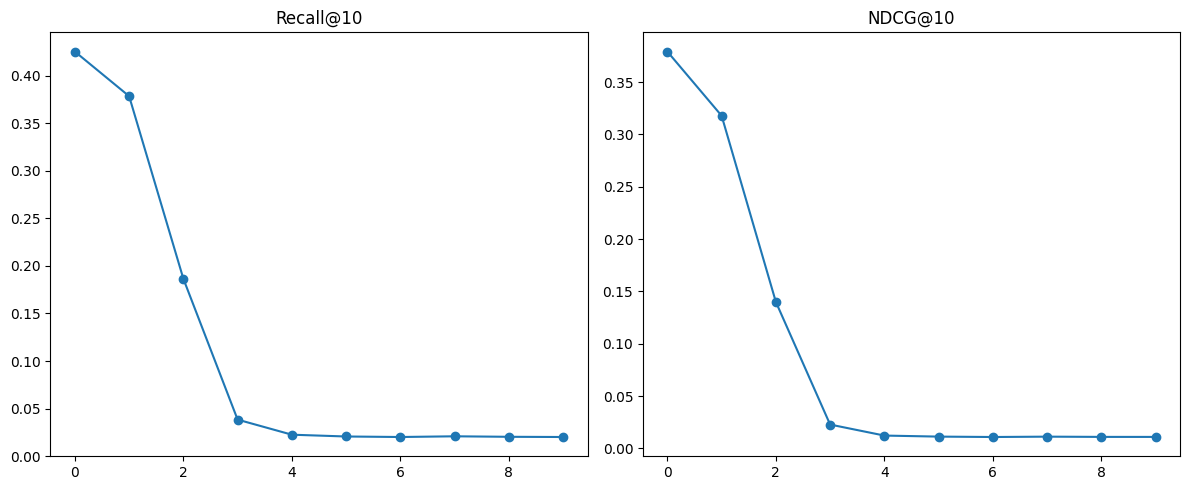

In [14]:
# ─── Imports & Config ─────────────────────────────────────
import pandas as pd, numpy as np, scipy.sparse as sp, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

LIKE_TH = 1
EPOCHS = 10
BASE_EMB_DIM = 64
N_LAYERS = 3
BATCH_SIZE = 4096
LR, WD = 1e-3, 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── Load Data & Build Graph ──────────────────────────────
def load_graph():
    rat = pd.read_csv("data/Ratings.csv")
    df = rat[rat["Book-Rating"] >= LIKE_TH].copy()

    uid = {u: i for i, u in enumerate(df["User-ID"].unique())}
    bid = {b: i for i, b in enumerate(df["ISBN"].unique())}

    df['u'] = df['User-ID'].map(uid)
    df['i'] = df['ISBN'].map(bid)

    n_u, n_i = len(uid), len(bid)

    ui = df[['u', 'i']].values
    row = np.concatenate([ui[:, 0], ui[:, 1] + n_u])
    col = np.concatenate([ui[:, 1] + n_u, ui[:, 0]])
    data = np.ones(len(row), dtype=np.float32)
    A = sp.coo_matrix((data, (row, col)), shape=(n_u + n_i, ) * 2).tocsr()

    d = np.array(A.sum(1)).flatten()
    d_inv = np.power(d, -0.5, where=d > 0)
    A = sp.diags(d_inv) @ A @ sp.diags(d_inv)
    A = A.tocoo()

    A = torch.sparse_coo_tensor(
        torch.LongTensor(np.vstack((A.row, A.col))),
        torch.FloatTensor(A.data),
        size=A.shape, device=DEVICE)

    df['rank'] = df.groupby('u')['Book-Rating'].rank(method='first', ascending=False)
    df['rank'] = pd.to_numeric(df['rank'], errors='coerce')
    df = df.dropna(subset=['rank'])
    df['rank'] = df['rank'].astype(int)

    test = df[df['rank'] == 1].copy()
    train = df[df['rank'] != 1].copy()

    return train, test, n_u, n_i, A

# ─── Dataset ──────────────────────────────────────────────
class PairDataset(Dataset):
    def __init__(self, df, n_items):
        self.u, self.p = df.u.values, df.i.values
        self.n_items = n_items
        self.seen = set(zip(self.u, self.p))
    def __len__(self): return len(self.u)
    def __getitem__(self, idx):
        u, p = self.u[idx], self.p[idx]
        n = np.random.randint(self.n_items)
        while (u, n) in self.seen: n = np.random.randint(self.n_items)
        return u, p, n

# ─── Model ────────────────────────────────────────────────
class LightGCN(nn.Module):
    def __init__(self, n_u, n_i, A):
        super().__init__()
        self.n_u, self.n_i = n_u, n_i
        self.A = A
        self.id_emb = nn.Embedding(n_u + n_i, BASE_EMB_DIM)
        nn.init.normal_(self.id_emb.weight, 0, 0.1)

    def get_embeddings(self):
        e = self.id_emb.weight
        embs = [e]
        for _ in range(N_LAYERS):
            e = torch.sparse.mm(self.A, e)
            embs.append(e)
        final = torch.stack(embs, 1).mean(1)
        return torch.split(final, [self.n_u, self.n_i])

    def forward(self, u, p, n):
        u_emb, i_emb = self.get_embeddings()
        u, p, n = u_emb[u], i_emb[p], i_emb[n]
        return (u * p).sum(1), (u * n).sum(1)

    @torch.inference_mode()
    def predict(self, users):
        u_emb, i_emb = self.get_embeddings()
        return u_emb[users] @ i_emb.T

# ─── Evaluation ───────────────────────────────────────────
def eval_model(model, test, train, top_k=10):
    model.eval(); hit = ndcg = tot = 0
    seen = train.groupby('u')['i'].apply(set).to_dict()
    users = test.u.unique(); batch_size = 256
    for s in range(0, len(users), batch_size):
        batch = users[s:s+batch_size]
        scores = model.predict(torch.tensor(batch, device=DEVICE)).clone()
        for j, u in enumerate(batch):
            if u in seen:
                scores[j, list(seen[u])] = -torch.inf
            top = torch.topk(scores[j], top_k).indices.cpu().numpy()
            pos = test[test.u == u].i.iloc[0]
            if pos in top:
                hit += 1
                r = np.where(top == pos)[0][0] + 1
                ndcg += 1 / np.log2(r + 1)
            tot += 1
    return hit / tot, ndcg / tot

# ─── Training ─────────────────────────────────────────────
train, test, n_u, n_i, A = load_graph()
dl = DataLoader(PairDataset(train, n_i), batch_size=BATCH_SIZE, shuffle=True)
model = LightGCN(n_u, n_i, A).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
bpr = lambda p, n: -torch.mean(torch.nn.functional.logsigmoid(p - n))

rec_hist, ndcg_hist = [], []
for epoch in trange(EPOCHS):
    model.train()
    for u, p, n in dl:
        u, p, n = (x.to(DEVICE) for x in (u, p, n))
        opt.zero_grad()
        pos, neg = model(u, p, n)
        bpr(pos, neg).backward(); opt.step()
    r, n = eval_model(model, test, train)
    rec_hist.append(r); ndcg_hist.append(n)
    print(f"Epoch {epoch+1:02d} | Recall@10 {r:.4f} | NDCG@10 {n:.4f}")

# ─── Plot ────────────────────────────────────────────────
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(rec_hist, 'o-'); plt.title("Recall@10")
plt.subplot(1, 2, 2); plt.plot(ndcg_hist, 'o-'); plt.title("NDCG@10")
plt.tight_layout(); plt.show()


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6517 │ Recall@10: 0.6025 │ NDCG@10: 0.4369


Epoch 2:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.5099 │ Recall@10: 0.6125 │ NDCG@10: 0.4439


Epoch 3:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.4200 │ Recall@10: 0.6260 │ NDCG@10: 0.4494


Epoch 4:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.3683 │ Recall@10: 0.6175 │ NDCG@10: 0.4540


Epoch 5:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.3327 │ Recall@10: 0.6225 │ NDCG@10: 0.4553


Epoch 6:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.3042 │ Recall@10: 0.6270 │ NDCG@10: 0.4571


Epoch 7:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.2793 │ Recall@10: 0.6280 │ NDCG@10: 0.4613


Epoch 8:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.2578 │ Recall@10: 0.6270 │ NDCG@10: 0.4621


Epoch 9:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.2399 │ Recall@10: 0.6280 │ NDCG@10: 0.4668


Epoch 10:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.2239 │ Recall@10: 0.6335 │ NDCG@10: 0.4630


Epoch 11:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.2110 │ Recall@10: 0.6330 │ NDCG@10: 0.4670


Epoch 12:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.1983 │ Recall@10: 0.6360 │ NDCG@10: 0.4632


Epoch 13:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.1892 │ Recall@10: 0.6345 │ NDCG@10: 0.4685


Epoch 14:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.1794 │ Recall@10: 0.6335 │ NDCG@10: 0.4689


Epoch 15:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.1722 │ Recall@10: 0.6345 │ NDCG@10: 0.4677


Epoch 16:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 16 │ Loss: 0.1632 │ Recall@10: 0.6365 │ NDCG@10: 0.4706


Epoch 17:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 17 │ Loss: 0.1557 │ Recall@10: 0.6360 │ NDCG@10: 0.4722


Epoch 18:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 18 │ Loss: 0.1494 │ Recall@10: 0.6440 │ NDCG@10: 0.4763


Epoch 19:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 19 │ Loss: 0.1433 │ Recall@10: 0.6340 │ NDCG@10: 0.4736


Epoch 20:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 20 │ Loss: 0.1365 │ Recall@10: 0.6400 │ NDCG@10: 0.4759


Epoch 21:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 21 │ Loss: 0.1314 │ Recall@10: 0.6365 │ NDCG@10: 0.4737


Epoch 22:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 22 │ Loss: 0.1246 │ Recall@10: 0.6375 │ NDCG@10: 0.4732


Epoch 23:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 23 │ Loss: 0.1206 │ Recall@10: 0.6395 │ NDCG@10: 0.4756


Epoch 24:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 24 │ Loss: 0.1155 │ Recall@10: 0.6460 │ NDCG@10: 0.4769


Epoch 25:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 25 │ Loss: 0.1121 │ Recall@10: 0.6415 │ NDCG@10: 0.4787


Epoch 26:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 26 │ Loss: 0.1074 │ Recall@10: 0.6450 │ NDCG@10: 0.4849


Epoch 27:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 27 │ Loss: 0.1030 │ Recall@10: 0.6475 │ NDCG@10: 0.4838


Epoch 28:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 28 │ Loss: 0.0999 │ Recall@10: 0.6490 │ NDCG@10: 0.4814


Epoch 29:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 29 │ Loss: 0.0955 │ Recall@10: 0.6445 │ NDCG@10: 0.4827


Epoch 30:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 30 │ Loss: 0.0932 │ Recall@10: 0.6480 │ NDCG@10: 0.4853


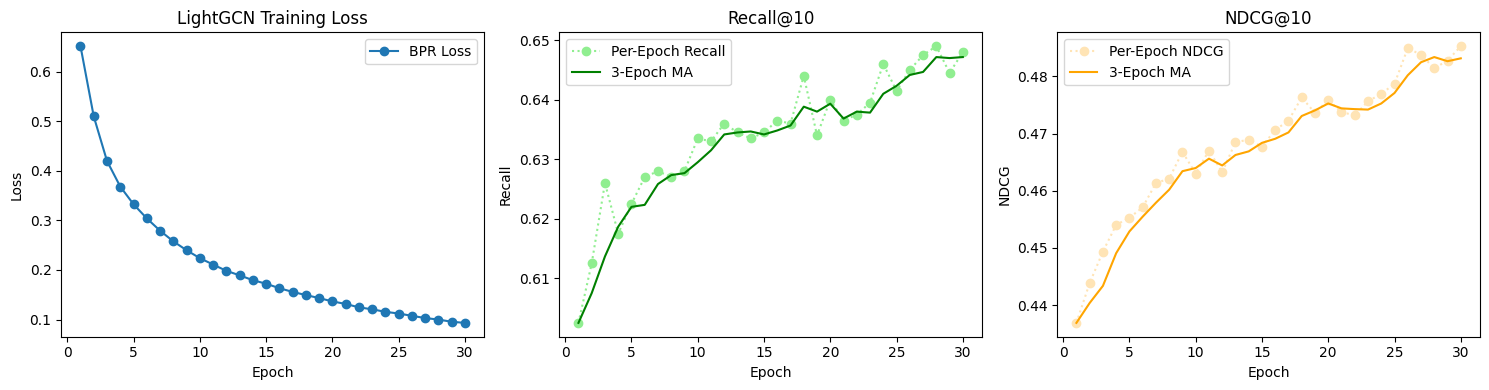

In [15]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange
import scipy.sparse as sp

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 30  # BPR often needs more epochs than NCF
EMB_DIM = 64
N_LAYERS = 3  # Number of graph convolution layers for LightGCN
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5 # L2 regularization term
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Load & Filter Ratings ────────────────────────────────────────
try:
    ratings_raw = pd.read_csv("data/Ratings.csv")
except FileNotFoundError:
    print("Error: 'data/Ratings.csv' not found.")
    exit()

ratings_raw = ratings_raw[ratings_raw["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
def train_test_split(df):
    df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
    train_df = df[df['rank_latest'] != 1]
    test_df = df[df['rank_latest'] == 1]
    return train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

train_df, test_df = train_test_split(ratings_raw)

# ─── 4 │ Encode IDs ───────────────────────────────────────────────────
user2idx = {u: i for i, u in enumerate(train_df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(train_df["ISBN"].unique())}

train_df["user_idx"] = train_df["User-ID"].map(user2idx)
train_df["book_idx"] = train_df["ISBN"].map(book2idx)
test_df["user_idx"] = test_df["User-ID"].map(user2idx)
test_df["book_idx"] = test_df["ISBN"].map(book2idx)

test_df = test_df.dropna().astype({"user_idx": int, "book_idx": int})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users, n_books = len(user2idx), len(book2idx)

# ─── 5 │ Create Interaction Graph ──────────────────────────────────────
def get_graph(train_df, n_users, n_books, device):
    """
    Creates a normalized adjacency matrix for the user-item interaction graph.
    """
    # Create the user-item interaction matrix (R)
    user_ids = train_df['user_idx'].values
    item_ids = train_df['book_idx'].values
    R = sp.coo_matrix((np.ones(len(user_ids)), (user_ids, item_ids)),
                      shape=(n_users, n_books), dtype=np.float32)

    # Create the adjacency matrix (A)
    adj_mat = sp.dok_matrix((n_users + n_books, n_users + n_books), dtype=np.float32)
    adj_mat = adj_mat.tolil()
    R = R.tolil()
    adj_mat[:n_users, n_users:] = R
    adj_mat[n_users:, :n_users] = R.T
    adj_mat = adj_mat.todok()

    # Symmetric normalization (D^-0.5 * A * D^-0.5)
    rowsum = np.array(adj_mat.sum(axis=1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    norm_adj_mat = d_mat_inv_sqrt.dot(adj_mat).dot(d_mat_inv_sqrt)

    # Convert to a PyTorch sparse tensor
    coo = norm_adj_mat.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    graph = torch.sparse_coo_tensor(i, v, torch.Size(shape)).to(device)
    return graph

graph = get_graph(train_df, n_users, n_books, DEVICE)


# ─── 6 │ LightGCN Dataset (Pairwise Samples) ──────────────────────────
class LightGCNDataset(Dataset):
    def __init__(self, df, n_books):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.n_books = n_books
        self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        item_pos = self.items[idx]
        
        # Sample a negative item
        item_neg = np.random.randint(self.n_books)
        while (user, item_neg) in self.user_item_set:
            item_neg = np.random.randint(self.n_books)
            
        return (
            torch.tensor(user, dtype=torch.long),
            torch.tensor(item_pos, dtype=torch.long),
            torch.tensor(item_neg, dtype=torch.long)
        )

train_ds = LightGCNDataset(train_df, n_books)
# No custom collate function needed for this simple triplet output
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# ─── 7 │ LightGCN Model Definition ────────────────────────────────────
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, n_layers, graph):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.graph = graph

        # Initial embeddings for users and items
        self.user_embedding = nn.Embedding(n_users, emb_dim)
        self.item_embedding = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def compute_embeddings(self):
        """
        Propagates embeddings through the graph layers.
        Returns the final embeddings as a weighted sum of all layers.
        """
        all_embeddings = torch.cat([self.user_embedding.weight, self.item_embedding.weight], dim=0)
        embeddings_list = [all_embeddings]

        for _ in range(self.n_layers):
            all_embeddings = torch.sparse.mm(self.graph, all_embeddings)
            embeddings_list.append(all_embeddings)
        
        # Final embeddings are the mean of embeddings from all layers
        final_embeddings = torch.mean(torch.stack(embeddings_list, dim=0), dim=0)
        users_emb, items_emb = torch.split(final_embeddings, [self.n_users, self.n_items])
        return users_emb, items_emb

    def forward(self, users, pos_items, neg_items):
        # Compute final embeddings after propagation
        all_users_emb, all_items_emb = self.compute_embeddings()
        
        # Get specific embeddings for the batch
        users_emb = all_users_emb[users]
        pos_items_emb = all_items_emb[pos_items]
        neg_items_emb = all_items_emb[neg_items]
        
        # Calculate scores (dot product)
        pos_scores = torch.sum(users_emb * pos_items_emb, dim=1)
        neg_scores = torch.sum(users_emb * neg_items_emb, dim=1)
        
        return pos_scores, neg_scores
    
    def predict(self, users):
        """For evaluation: get scores for all items for a given set of users"""
        all_users_emb, all_items_emb = self.compute_embeddings()
        
        users_emb = all_users_emb[users]
        # Calculate scores against all items
        all_scores = torch.matmul(users_emb, all_items_emb.t())
        return all_scores

def bpr_loss(pos_scores, neg_scores):
    """Bayesian Personalized Ranking loss."""
    return -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-9).mean()

model = LightGCN(n_users, n_books, EMB_DIM, N_LAYERS, graph).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # weight_decay handled by AdamW or by adding a term to the loss

# ─── 8 │ Evaluation Function ──────────────────────────────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    # Get final embeddings for all users and items once
    final_users_emb, final_items_emb = model.compute_embeddings()

    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            seen_books = train_history.get(u_idx, set())
            
            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = [pos_b_idx] + neg_b_indices
            
            # Get embeddings for the user and the evaluation items
            user_emb = final_users_emb[u_idx].unsqueeze(0) # [1, D]
            item_embs = final_items_emb[eval_b_indices] # [101, D]
            
            # Compute scores
            scores = (user_emb @ item_embs.t()).squeeze() # [101]
            scores = scores.cpu().numpy()

            # The positive item is at index 0
            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 9 │ Training & Evaluation Loop ───────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, pos_items, neg_items in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        users, pos_items, neg_items = users.to(DEVICE), pos_items.to(DEVICE), neg_items.to(DEVICE)
        
        opt.zero_grad()
        
        # Forward pass
        pos_scores, neg_scores = model(users, pos_items, neg_items)
        
        # Compute BPR loss
        loss = bpr_loss(pos_scores, neg_scores)
        
        # Add L2 regularization
        # AdamW does this implicitly, but for other optimizers you can add it manually:
        reg_loss = (
             model.user_embedding.weight[users].norm(2).pow(2) +
             model.item_embedding.weight[pos_items].norm(2).pow(2) +
             model.item_embedding.weight[neg_items].norm(2).pow(2)
        ) / len(users)
        
        loss += WEIGHT_DECAY * reg_loss
        
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")


# ─── 10 │ Plotting Results ────────────────────────────────────────────
window_size = 3
recall_ma = pd.Series(recall_hist).rolling(window_size, min_periods=1).mean()
ndcg_ma = pd.Series(ndcg_hist).rolling(window_size, min_periods=1).mean()

plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss_hist, marker='o', linestyle='-', label='BPR Loss')
plt.title("LightGCN Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

# Recall@10
plt.subplot(1, 3, 2)
plt.plot(epochs_range, recall_hist, marker='o', linestyle=':', color='lightgreen', label='Per-Epoch Recall')
plt.plot(epochs_range, recall_ma, color='green', label=f'{window_size}-Epoch MA')
plt.title("Recall@10")
plt.xlabel("Epoch"); plt.ylabel("Recall")
plt.legend()

# NDCG@10
plt.subplot(1, 3, 3)
plt.plot(epochs_range, ndcg_hist, marker='o', linestyle=':', color='moccasin', label='Per-Epoch NDCG')
plt.plot(epochs_range, ndcg_ma, color='orange', label=f'{window_size}-Epoch MA')
plt.title("NDCG@10")
plt.xlabel("Epoch"); plt.ylabel("NDCG")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ─── Imports & Config ─────────────────────────────────────
import pandas as pd, numpy as np, scipy.sparse as sp, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

LIKE_TH = 1
EPOCHS = 10
BASE_EMB_DIM = 64
N_LAYERS = 3
BATCH_SIZE = 4096
LR, WD = 1e-3, 1e-5
CLUSTER_WEIGHT = 0.1  # ← reduced to mitigate overfitting
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── Load Data & Build Graph ──────────────────────────────
def load_graph():
    rat = pd.read_csv("data/Ratings.csv")
    clust = pd.read_csv("clustered_outputs/clustered_books_metadata.csv")
    df = rat[rat["Book-Rating"] >= LIKE_TH].copy()

    uid = {u: i for i, u in enumerate(df["User-ID"].unique())}
    bid = {b: i for i, b in enumerate(df["ISBN"].unique())}
    cid = {b: c for b, c in zip(clust.ISBN, clust.genre_cluster)}

    df['u'] = df['User-ID'].map(uid)
    df['i'] = df['ISBN'].map(bid)
    df['c'] = df['ISBN'].map(cid)
    df = df.dropna(subset=['u', 'i', 'c'])
    df['c'] = df['c'].astype(int)

    n_u, n_i, n_c = len(uid), len(bid), df['c'].max() + 1

    ui = df[['u', 'i']].values
    row = np.concatenate([ui[:, 0], ui[:, 1] + n_u])
    col = np.concatenate([ui[:, 1] + n_u, ui[:, 0]])
    data = np.ones(len(row), dtype=np.float32)
    A = sp.coo_matrix((data, (row, col)), shape=(n_u + n_i, ) * 2).tocsr()

    d = np.array(A.sum(1)).flatten()
    d_inv = np.power(d, -0.5, where=d > 0)
    A = sp.diags(d_inv) @ A @ sp.diags(d_inv)
    A = A.tocoo()

    A = torch.sparse_coo_tensor(
        torch.LongTensor(np.vstack((A.row, A.col))),
        torch.FloatTensor(A.data),
        size=A.shape, device=DEVICE)

    df['rank'] = df.groupby('u')['Book-Rating'].rank(method='first', ascending=False)
    df['rank'] = pd.to_numeric(df['rank'], errors='coerce')
    df = df.dropna(subset=['rank'])
    df['rank'] = df['rank'].astype(int)

    test = df[df['rank'] == 1].copy()
    train = df[df['rank'] != 1].copy()

    return train, test, n_u, n_i, n_c, A

# ─── Dataset ──────────────────────────────────────────────
class PairDataset(Dataset):
    def __init__(self, df, n_items):
        self.u, self.p, self.c = df.u.values, df.i.values, df.c.values
        self.n_items = n_items
        self.seen = set(zip(self.u, self.p))
    def __len__(self): return len(self.u)
    def __getitem__(self, idx):
        u, p, c = self.u[idx], self.p[idx], self.c[idx]
        n = np.random.randint(self.n_items)
        while (u, n) in self.seen: n = np.random.randint(self.n_items)
        return u, p, c, n

# ─── Model ────────────────────────────────────────────────
class LightGCN(nn.Module):
    def __init__(self, n_u, n_i, n_c, A):
        super().__init__()
        self.n_u, self.n_i = n_u, n_i
        self.A = A
        self.id_emb = nn.Embedding(n_u + n_i, BASE_EMB_DIM)
        self.cluster_emb = nn.Embedding(n_c, BASE_EMB_DIM)
        nn.init.normal_(self.id_emb.weight, 0, 0.1)
        nn.init.normal_(self.cluster_emb.weight, 0, 0.1)

    def get_embeddings(self):
        e = self.id_emb.weight
        embs = [e]
        for _ in range(N_LAYERS):
            e = torch.sparse.mm(self.A, e)
            embs.append(e)
        final = torch.stack(embs, 1).mean(1)
        return torch.split(final, [self.n_u, self.n_i])

    def forward(self, u, p, c, n):
        u_emb, i_emb = self.get_embeddings()
        u, p, n = u_emb[u], i_emb[p], i_emb[n]
        c = self.cluster_emb(c)
        return (u * (p + CLUSTER_WEIGHT * c)).sum(1), (u * n).sum(1)

    @torch.inference_mode()
    def predict(self, users):
        u_emb, i_emb = self.get_embeddings()
        return u_emb[users] @ i_emb.T

# ─── Evaluation ───────────────────────────────────────────
def eval_model(model, test, train, top_k=10):
    model.eval(); hit = ndcg = tot = 0
    seen = train.groupby('u')['i'].apply(set).to_dict()
    users = test.u.unique(); batch_size = 256
    for s in range(0, len(users), batch_size):
        batch = users[s:s+batch_size]
        scores = model.predict(torch.tensor(batch, device=DEVICE)).clone()
        for j, u in enumerate(batch):
            if u in seen:
                scores[j, list(seen[u])] = -torch.inf
            top = torch.topk(scores[j], top_k).indices.cpu().numpy()
            pos = test[test.u == u].i.iloc[0]
            if pos in top:
                hit += 1
                r = np.where(top == pos)[0][0] + 1
                ndcg += 1 / np.log2(r + 1)
            tot += 1
    return hit / tot, ndcg / tot

# ─── Training ─────────────────────────────────────────────
train, test, n_u, n_i, n_c, A = load_graph()
dl = DataLoader(PairDataset(train, n_i), batch_size=BATCH_SIZE, shuffle=True)
model = LightGCN(n_u, n_i, n_c, A).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
bpr = lambda p, n: -torch.mean(torch.nn.functional.logsigmoid(p - n))

rec_hist, ndcg_hist, loss_hist = [], [], []
for epoch in trange(EPOCHS):
    model.train(); total_loss = 0
    for u, p, c, n in dl:
        u, p, c, n = (x.to(DEVICE) for x in (u, p, c, n))
        opt.zero_grad()
        pos, neg = model(u, p, c, n)
        loss = bpr(pos, neg)
        loss.backward(); opt.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dl)
    loss_hist.append(avg_loss)
    r, n = eval_model(model, test, train)
    rec_hist.append(r); ndcg_hist.append(n)
    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Recall@10: {r:.4f} | NDCG@10: {n:.4f}")

# ─── Plot ────────────────────────────────────────────────
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1); plt.plot(loss_hist, 'o-'); plt.title("BPR Loss")
plt.subplot(1, 3, 2); plt.plot(rec_hist, 'o-'); plt.title("Recall@10")
plt.subplot(1, 3, 3); plt.plot(ndcg_hist, 'o-'); plt.title("NDCG@10")
plt.tight_layout(); plt.show()


[I 2025-07-26 22:23:55,675] A new study created in memory with name: no-name-7ec70e88-e0e4-448c-9acf-60152ad85fc9
C:\Users\a.khajooei\AppData\Local\Temp\ipykernel_26792\1760239235.py:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
C:\Users\a.khajooei\AppData\Local\Temp\ipykernel_26792\1760239235.py:138: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
[I 2025-07-26 22:26:21,438] Trial 0 finished with value: -0.4163025600796974 and parameters: {'emb_dim': 128, 'n_layers': 1, 'lr': 0.0001252234630992133, 'weight_decay': 0.0005743884783953808}. Best is trial 

🎯 Trial 00 │ Recall@10=0.5635, NDCG@10=0.4163, Params={'emb_dim': 128, 'n_layers': 1, 'lr': 0.0001252234630992133, 'weight_decay': 0.0005743884783953808}


[I 2025-07-26 22:28:51,165] Trial 1 finished with value: -0.45038513883833264 and parameters: {'emb_dim': 128, 'n_layers': 1, 'lr': 0.0006448482900236062, 'weight_decay': 1.343344246410908e-06}. Best is trial 1 with value: -0.45038513883833264.


🎯 Trial 01 │ Recall@10=0.6005, NDCG@10=0.4504, Params={'emb_dim': 128, 'n_layers': 1, 'lr': 0.0006448482900236062, 'weight_decay': 1.343344246410908e-06}


[I 2025-07-26 22:32:16,163] Trial 2 finished with value: -0.46766095287614046 and parameters: {'emb_dim': 64, 'n_layers': 3, 'lr': 0.0006284447462524492, 'weight_decay': 5.933041152734917e-06}. Best is trial 2 with value: -0.46766095287614046.


🎯 Trial 02 │ Recall@10=0.6380, NDCG@10=0.4677, Params={'emb_dim': 64, 'n_layers': 3, 'lr': 0.0006284447462524492, 'weight_decay': 5.933041152734917e-06}


[I 2025-07-26 22:36:43,874] Trial 3 finished with value: -0.4780046408754397 and parameters: {'emb_dim': 128, 'n_layers': 2, 'lr': 0.003066633089535785, 'weight_decay': 0.0005277930715120619}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 03 │ Recall@10=0.6340, NDCG@10=0.4780, Params={'emb_dim': 128, 'n_layers': 2, 'lr': 0.003066633089535785, 'weight_decay': 0.0005277930715120619}


[I 2025-07-26 22:42:20,068] Trial 4 finished with value: -0.4595738633562278 and parameters: {'emb_dim': 128, 'n_layers': 2, 'lr': 0.005371175337174858, 'weight_decay': 2.9453461603319635e-05}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 04 │ Recall@10=0.6130, NDCG@10=0.4596, Params={'emb_dim': 128, 'n_layers': 2, 'lr': 0.005371175337174858, 'weight_decay': 2.9453461603319635e-05}


[I 2025-07-26 22:46:31,925] Trial 5 finished with value: -0.4308784091916073 and parameters: {'emb_dim': 128, 'n_layers': 1, 'lr': 0.006054201790766127, 'weight_decay': 2.8325671004360207e-06}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 05 │ Recall@10=0.5875, NDCG@10=0.4309, Params={'emb_dim': 128, 'n_layers': 1, 'lr': 0.006054201790766127, 'weight_decay': 2.8325671004360207e-06}


[I 2025-07-26 22:51:42,341] Trial 6 finished with value: -0.47275974452535013 and parameters: {'emb_dim': 128, 'n_layers': 2, 'lr': 0.000572390386541456, 'weight_decay': 1.2798953521520561e-05}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 06 │ Recall@10=0.6370, NDCG@10=0.4728, Params={'emb_dim': 128, 'n_layers': 2, 'lr': 0.000572390386541456, 'weight_decay': 1.2798953521520561e-05}


[I 2025-07-26 22:54:32,541] Trial 7 finished with value: -0.4064968518626557 and parameters: {'emb_dim': 128, 'n_layers': 1, 'lr': 0.009118760767217548, 'weight_decay': 1.0764774866539458e-05}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 07 │ Recall@10=0.5565, NDCG@10=0.4065, Params={'emb_dim': 128, 'n_layers': 1, 'lr': 0.009118760767217548, 'weight_decay': 1.0764774866539458e-05}


[I 2025-07-26 22:56:58,404] Trial 8 finished with value: -0.4158334106640995 and parameters: {'emb_dim': 128, 'n_layers': 1, 'lr': 0.00016827096524635175, 'weight_decay': 0.0028802579076372564}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 08 │ Recall@10=0.5690, NDCG@10=0.4158, Params={'emb_dim': 128, 'n_layers': 1, 'lr': 0.00016827096524635175, 'weight_decay': 0.0028802579076372564}


[I 2025-07-26 22:59:22,345] Trial 9 finished with value: -0.45310286195006383 and parameters: {'emb_dim': 32, 'n_layers': 3, 'lr': 0.0003204665949864392, 'weight_decay': 1.6359134903891508e-05}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 09 │ Recall@10=0.6230, NDCG@10=0.4531, Params={'emb_dim': 32, 'n_layers': 3, 'lr': 0.0003204665949864392, 'weight_decay': 1.6359134903891508e-05}


[I 2025-07-26 23:01:23,266] Trial 10 finished with value: -0.46890567936569094 and parameters: {'emb_dim': 32, 'n_layers': 2, 'lr': 0.0021410387562482616, 'weight_decay': 0.00022782353578848171}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 10 │ Recall@10=0.6410, NDCG@10=0.4689, Params={'emb_dim': 32, 'n_layers': 2, 'lr': 0.0021410387562482616, 'weight_decay': 0.00022782353578848171}


[I 2025-07-26 23:03:56,389] Trial 11 finished with value: -0.47619907594265526 and parameters: {'emb_dim': 64, 'n_layers': 2, 'lr': 0.001726593469658792, 'weight_decay': 8.531297008508823e-05}. Best is trial 3 with value: -0.4780046408754397.


🎯 Trial 11 │ Recall@10=0.6375, NDCG@10=0.4762, Params={'emb_dim': 64, 'n_layers': 2, 'lr': 0.001726593469658792, 'weight_decay': 8.531297008508823e-05}


[I 2025-07-26 23:06:27,945] Trial 12 finished with value: -0.4783224544282233 and parameters: {'emb_dim': 64, 'n_layers': 2, 'lr': 0.002056952836825544, 'weight_decay': 0.0017260797500331202}. Best is trial 12 with value: -0.4783224544282233.


🎯 Trial 12 │ Recall@10=0.6450, NDCG@10=0.4783, Params={'emb_dim': 64, 'n_layers': 2, 'lr': 0.002056952836825544, 'weight_decay': 0.0017260797500331202}


[I 2025-07-26 23:08:57,904] Trial 13 finished with value: -0.4733445826971524 and parameters: {'emb_dim': 64, 'n_layers': 2, 'lr': 0.002435549497158129, 'weight_decay': 0.0060207203463082636}. Best is trial 12 with value: -0.4783224544282233.


🎯 Trial 13 │ Recall@10=0.6425, NDCG@10=0.4733, Params={'emb_dim': 64, 'n_layers': 2, 'lr': 0.002435549497158129, 'weight_decay': 0.0060207203463082636}


[I 2025-07-26 23:12:13,642] Trial 14 finished with value: -0.4732264818096835 and parameters: {'emb_dim': 64, 'n_layers': 3, 'lr': 0.0032902676491220095, 'weight_decay': 0.0012438850262593368}. Best is trial 12 with value: -0.4783224544282233.


🎯 Trial 14 │ Recall@10=0.6320, NDCG@10=0.4732, Params={'emb_dim': 64, 'n_layers': 3, 'lr': 0.0032902676491220095, 'weight_decay': 0.0012438850262593368}


[I 2025-07-26 23:14:42,313] Trial 15 finished with value: -0.4742133176899174 and parameters: {'emb_dim': 64, 'n_layers': 2, 'lr': 0.001234191236893218, 'weight_decay': 0.00044900721431758914}. Best is trial 12 with value: -0.4783224544282233.


🎯 Trial 15 │ Recall@10=0.6435, NDCG@10=0.4742, Params={'emb_dim': 64, 'n_layers': 2, 'lr': 0.001234191236893218, 'weight_decay': 0.00044900721431758914}


[I 2025-07-26 23:16:37,691] Trial 16 finished with value: -0.46576892115573715 and parameters: {'emb_dim': 32, 'n_layers': 2, 'lr': 0.004256486496022856, 'weight_decay': 0.00829421899077616}. Best is trial 12 with value: -0.4783224544282233.


🎯 Trial 16 │ Recall@10=0.6270, NDCG@10=0.4658, Params={'emb_dim': 32, 'n_layers': 2, 'lr': 0.004256486496022856, 'weight_decay': 0.00829421899077616}


[I 2025-07-26 23:19:51,924] Trial 17 finished with value: -0.4780122257873661 and parameters: {'emb_dim': 64, 'n_layers': 3, 'lr': 0.00119889683413401, 'weight_decay': 0.001750530293817341}. Best is trial 12 with value: -0.4783224544282233.


🎯 Trial 17 │ Recall@10=0.6485, NDCG@10=0.4780, Params={'emb_dim': 64, 'n_layers': 3, 'lr': 0.00119889683413401, 'weight_decay': 0.001750530293817341}


[I 2025-07-26 23:23:05,719] Trial 18 finished with value: -0.4711517865916054 and parameters: {'emb_dim': 64, 'n_layers': 3, 'lr': 0.0012332073165337728, 'weight_decay': 0.002248339475556319}. Best is trial 12 with value: -0.4783224544282233.


🎯 Trial 18 │ Recall@10=0.6410, NDCG@10=0.4712, Params={'emb_dim': 64, 'n_layers': 3, 'lr': 0.0012332073165337728, 'weight_decay': 0.002248339475556319}


[I 2025-07-26 23:26:19,435] Trial 19 finished with value: -0.45312459024618434 and parameters: {'emb_dim': 64, 'n_layers': 3, 'lr': 0.0003393232616725324, 'weight_decay': 8.683689114432945e-05}. Best is trial 12 with value: -0.4783224544282233.


🎯 Trial 19 │ Recall@10=0.6285, NDCG@10=0.4531, Params={'emb_dim': 64, 'n_layers': 3, 'lr': 0.0003393232616725324, 'weight_decay': 8.683689114432945e-05}

✅ Best Hyperparameters: {'emb_dim': 64, 'n_layers': 2, 'lr': 0.002056952836825544, 'weight_decay': 0.0017260797500331202}
🏆 Best Recall@10: 0.6450
🏆 Best NDCG@10: 0.4783


C:\Users\a.khajooei\AppData\Local\Temp\ipykernel_26792\1760239235.py:179: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\a.khajooei\AppData\Local\Temp\ipykernel_26792\1760239235.py:180: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


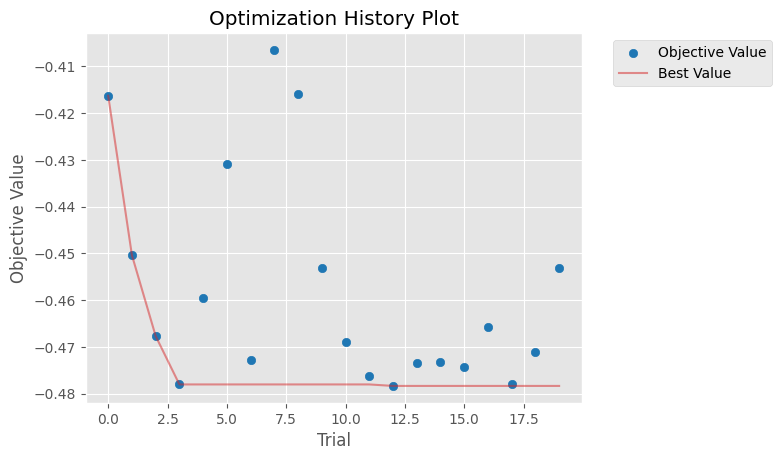

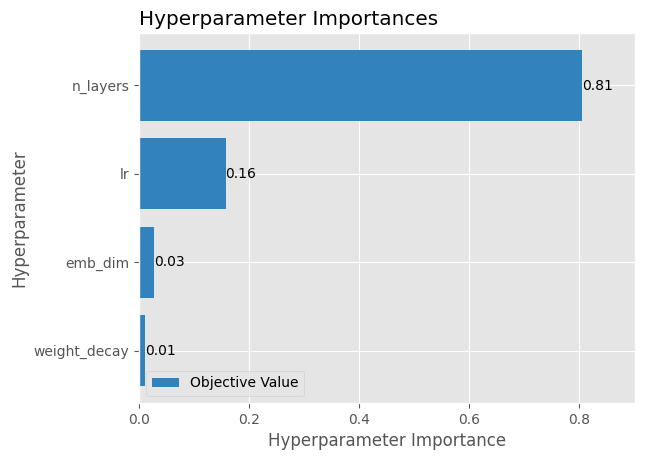

In [1]:
# ─── 0 │ Imports ─────────────────────────────────────────────────────
import pandas as pd, torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import scipy.sparse as sp
from tqdm.auto import tqdm
import optuna

# ─── 1 │ Config & Hyperparams ────────────────────────────────────────
LIKE_TH = 1
BATCH_SIZE = 4096
EPOCHS = 10  # Use fewer epochs during tuning
DEVICE = "cuda" 

# ─── 2 │ Load & Prepare Dataset ───────────────────────────────────────
ratings_raw = pd.read_csv("data/Ratings.csv")
ratings_raw = ratings_raw[ratings_raw["Book-Rating"] >= LIKE_TH]

def train_test_split(df):
    df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
    train_df = df[df['rank_latest'] != 1]
    test_df = df[df['rank_latest'] == 1]
    return train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

train_df, test_df = train_test_split(ratings_raw)

user2idx = {u: i for i, u in enumerate(train_df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(train_df["ISBN"].unique())}

train_df["user_idx"] = train_df["User-ID"].map(user2idx)
train_df["book_idx"] = train_df["ISBN"].map(book2idx)
test_df["user_idx"] = test_df["User-ID"].map(user2idx)
test_df["book_idx"] = test_df["ISBN"].map(book2idx)
test_df = test_df.dropna().astype({"user_idx": int, "book_idx": int})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users, n_books = len(user2idx), len(book2idx)

def get_graph(train_df, n_users, n_books):
    user_ids = train_df['user_idx'].values
    item_ids = train_df['book_idx'].values
    R = sp.coo_matrix((np.ones(len(user_ids)), (user_ids, item_ids)),
                      shape=(n_users, n_books), dtype=np.float32)

    adj_mat = sp.dok_matrix((n_users + n_books, n_users + n_books), dtype=np.float32).tolil()
    R = R.tolil()
    adj_mat[:n_users, n_users:] = R
    adj_mat[n_users:, :n_users] = R.T
    adj_mat = adj_mat.todok()

    rowsum = np.array(adj_mat.sum(axis=1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    norm_adj_mat = d_mat_inv_sqrt.dot(adj_mat).dot(d_mat_inv_sqrt)

    coo = norm_adj_mat.tocoo()
    i = torch.LongTensor(np.vstack((coo.row, coo.col)))
    v = torch.FloatTensor(coo.data)
    shape = coo.shape
    return torch.sparse_coo_tensor(i, v, torch.Size(shape)).to(DEVICE)

graph = get_graph(train_df, n_users, n_books)

class LightGCNDataset(Dataset):
    def __init__(self, df, n_books):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.n_books = n_books
        self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        pos_item = self.items[idx]
        neg_item = np.random.randint(self.n_books)
        while (user, neg_item) in self.user_item_set:
            neg_item = np.random.randint(self.n_books)
        return torch.tensor(user), torch.tensor(pos_item), torch.tensor(neg_item)

train_ds = LightGCNDataset(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, n_layers, graph):
        super().__init__()
        self.n_users, self.n_items = n_users, n_items
        self.emb_dim, self.n_layers = emb_dim, n_layers
        self.graph = graph
        self.user_embedding = nn.Embedding(n_users, emb_dim)
        self.item_embedding = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def compute_embeddings(self):
        all_emb = torch.cat([self.user_embedding.weight, self.item_embedding.weight], dim=0)
        embs = [all_emb]
        for _ in range(self.n_layers):
            all_emb = torch.sparse.mm(self.graph, all_emb)
            embs.append(all_emb)
        final_emb = torch.mean(torch.stack(embs, dim=0), dim=0)
        return torch.split(final_emb, [self.n_users, self.n_items])

    def forward(self, users, pos_items, neg_items):
        user_emb, item_emb = self.compute_embeddings()
        u, pi, ni = user_emb[users], item_emb[pos_items], item_emb[neg_items]
        return (u * pi).sum(1), (u * ni).sum(1)

def bpr_loss(pos_scores, neg_scores):
    return -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-9).mean()

def evaluate(model, test_df, train_df, top_k=10):
    model.eval()
    u_emb, i_emb = model.compute_embeddings()
    train_hist = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    total, hits, ndcg_sum = 0, 0, 0
    with torch.no_grad():
        for _, row in test_df.iterrows():
            u, pos = int(row["user_idx"]), int(row["book_idx"])
            seen = train_hist.get(u, set())
            candidates = list(set(np.random.choice(n_books, 100, replace=False)) - seen)
            candidates = candidates[:99] + [pos]
            scores = torch.matmul(u_emb[u], i_emb[candidates].T)
            rank = (scores >= scores[-1]).sum().item()
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1
    return hits / total, ndcg_sum / total

# ─── 3 │ Optuna Objective ─────────────────────────────────────────────
def objective(trial):
    emb_dim = trial.suggest_categorical("emb_dim", [32, 64, 128])
    n_layers = trial.suggest_int("n_layers", 1, 3)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)

    model = LightGCN(n_users, n_books, emb_dim, n_layers, graph).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(EPOCHS):
        model.train()
        for users, pos_items, neg_items in train_dl:
            users, pos_items, neg_items = users.to(DEVICE), pos_items.to(DEVICE), neg_items.to(DEVICE)
            optimizer.zero_grad()
            pos_scores, neg_scores = model(users, pos_items, neg_items)
            loss = bpr_loss(pos_scores, neg_scores)
            reg_loss = (
                model.user_embedding.weight[users].norm(2).pow(2) +
                model.item_embedding.weight[pos_items].norm(2).pow(2) +
                model.item_embedding.weight[neg_items].norm(2).pow(2)
            ) / len(users)
            loss += weight_decay * reg_loss
            loss.backward()
            optimizer.step()

    recall, ndcg = evaluate(model, test_df, train_df)
    trial.set_user_attr("recall@10", recall)
    trial.set_user_attr("ndcg@10", ndcg)
    return -ndcg

# ─── 4 │ Study with Live Logging ──────────────────────────────────────
def print_callback(study, trial):
    recall = trial.user_attrs.get("recall@10", "N/A")
    ndcg = trial.user_attrs.get("ndcg@10", "N/A")
    print(f"🎯 Trial {trial.number:02d} │ Recall@10={recall:.4f}, NDCG@10={ndcg:.4f}, Params={trial.params}")

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, callbacks=[print_callback])

# ─── 5 │ Results & Visualization ─────────────────────────────────────
print("\n✅ Best Hyperparameters:", study.best_params)
print(f"🏆 Best Recall@10: {study.best_trial.user_attrs['recall@10']:.4f}")
print(f"🏆 Best NDCG@10: {study.best_trial.user_attrs['ndcg@10']:.4f}")

# Optional (if matplotlib backend is supported)
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6753 │ Recall@10: 0.5445 │ NDCG@10: 0.3929


Epoch 2:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.5909 │ Recall@10: 0.5765 │ NDCG@10: 0.4224


Epoch 3:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.4953 │ Recall@10: 0.5950 │ NDCG@10: 0.4386


Epoch 4:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.4261 │ Recall@10: 0.6125 │ NDCG@10: 0.4405


Epoch 5:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.3782 │ Recall@10: 0.6120 │ NDCG@10: 0.4430


Epoch 6:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.3422 │ Recall@10: 0.6105 │ NDCG@10: 0.4495


Epoch 7:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.3133 │ Recall@10: 0.6155 │ NDCG@10: 0.4508


Epoch 8:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.2902 │ Recall@10: 0.6165 │ NDCG@10: 0.4522


Epoch 9:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.2706 │ Recall@10: 0.6170 │ NDCG@10: 0.4496


Epoch 10:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.2540 │ Recall@10: 0.6240 │ NDCG@10: 0.4548


Epoch 11:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.2375 │ Recall@10: 0.6235 │ NDCG@10: 0.4559


Epoch 12:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.2243 │ Recall@10: 0.6230 │ NDCG@10: 0.4618


Epoch 13:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.2128 │ Recall@10: 0.6285 │ NDCG@10: 0.4641


Epoch 14:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.2018 │ Recall@10: 0.6250 │ NDCG@10: 0.4608


Epoch 15:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.1911 │ Recall@10: 0.6355 │ NDCG@10: 0.4638


Epoch 16:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 16 │ Loss: 0.1830 │ Recall@10: 0.6335 │ NDCG@10: 0.4663


Epoch 17:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 17 │ Loss: 0.1741 │ Recall@10: 0.6345 │ NDCG@10: 0.4680


Epoch 18:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 18 │ Loss: 0.1668 │ Recall@10: 0.6305 │ NDCG@10: 0.4682


Epoch 19:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 19 │ Loss: 0.1589 │ Recall@10: 0.6440 │ NDCG@10: 0.4711


Epoch 20:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 20 │ Loss: 0.1527 │ Recall@10: 0.6335 │ NDCG@10: 0.4678


Epoch 21:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 21 │ Loss: 0.1466 │ Recall@10: 0.6380 │ NDCG@10: 0.4704


Epoch 22:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 22 │ Loss: 0.1406 │ Recall@10: 0.6450 │ NDCG@10: 0.4728


Epoch 23:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 23 │ Loss: 0.1351 │ Recall@10: 0.6410 │ NDCG@10: 0.4703


Epoch 24:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 24 │ Loss: 0.1302 │ Recall@10: 0.6370 │ NDCG@10: 0.4693


Epoch 25:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 25 │ Loss: 0.1253 │ Recall@10: 0.6430 │ NDCG@10: 0.4725


Epoch 26:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 26 │ Loss: 0.1191 │ Recall@10: 0.6435 │ NDCG@10: 0.4722


Epoch 27:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 27 │ Loss: 0.1154 │ Recall@10: 0.6415 │ NDCG@10: 0.4710


Epoch 28:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 28 │ Loss: 0.1116 │ Recall@10: 0.6465 │ NDCG@10: 0.4722


Epoch 29:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 29 │ Loss: 0.1076 │ Recall@10: 0.6470 │ NDCG@10: 0.4792


Epoch 30:   0%|          | 0/87 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 30 │ Loss: 0.1038 │ Recall@10: 0.6385 │ NDCG@10: 0.4747


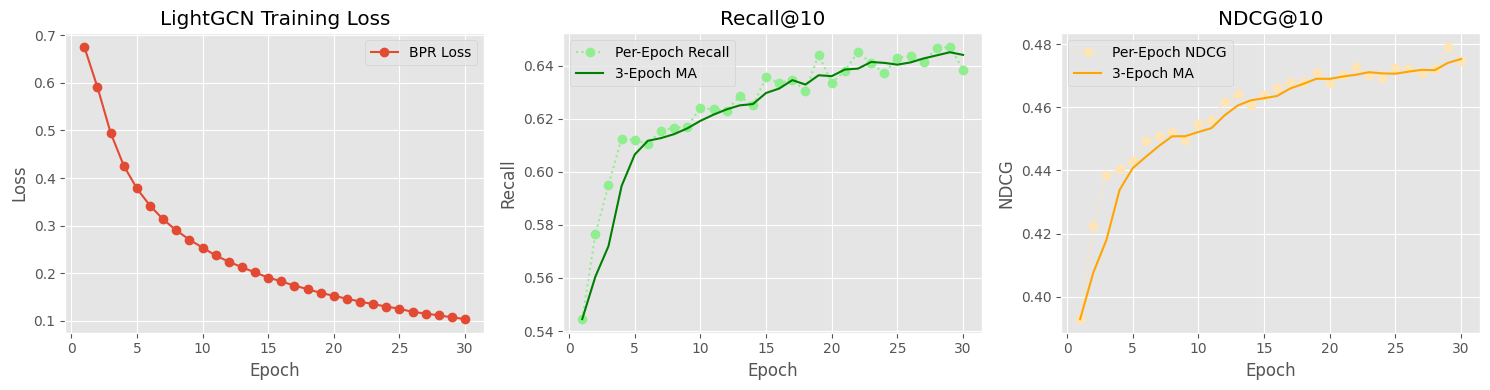

In [ ]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange
import scipy.sparse as sp

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 30
EMB_DIM = 64
N_LAYERS = 2
BATCH_SIZE = 4096
LEARNING_RATE = 7e-4
WEIGHT_DECAY = 3.2e-5
DEVICE = "cuda"

# ─── 2 │ Load & Filter Ratings ────────────────────────────────────────
ratings_raw = pd.read_csv("data/Ratings.csv")
ratings_raw = ratings_raw[ratings_raw["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
def train_test_split(df):
    df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
    train_df = df[df['rank_latest'] != 1]
    test_df = df[df['rank_latest'] == 1]
    return train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

train_df, test_df = train_test_split(ratings_raw)

# ─── 4 │ Encode IDs ───────────────────────────────────────────────────
user2idx = {u: i for i, u in enumerate(train_df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(train_df["ISBN"].unique())}

train_df["user_idx"] = train_df["User-ID"].map(user2idx)
train_df["book_idx"] = train_df["ISBN"].map(book2idx)
test_df["user_idx"] = test_df["User-ID"].map(user2idx)
test_df["book_idx"] = test_df["ISBN"].map(book2idx)

test_df = test_df.dropna().astype({"user_idx": int, "book_idx": int})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users, n_books = len(user2idx), len(book2idx)

# ─── 5 │ Create Interaction Graph ──────────────────────────────────────
def get_graph(train_df, n_users, n_books, device):
    user_ids = train_df['user_idx'].values
    item_ids = train_df['book_idx'].values
    R = sp.coo_matrix((np.ones(len(user_ids)), (user_ids, item_ids)),
                      shape=(n_users, n_books), dtype=np.float32)

    adj_mat = sp.dok_matrix((n_users + n_books, n_users + n_books), dtype=np.float32)
    adj_mat = adj_mat.tolil()
    R = R.tolil()
    adj_mat[:n_users, n_users:] = R
    adj_mat[n_users:, :n_users] = R.T
    adj_mat = adj_mat.todok()

    rowsum = np.array(adj_mat.sum(axis=1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    norm_adj_mat = d_mat_inv_sqrt.dot(adj_mat).dot(d_mat_inv_sqrt)

    coo = norm_adj_mat.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    graph = torch.sparse_coo_tensor(i, v, torch.Size(shape)).to(device)
    return graph

graph = get_graph(train_df, n_users, n_books, DEVICE)

# ─── 6 │ LightGCN Dataset ─────────────────────────────────────────────
class LightGCNDataset(Dataset):
    def __init__(self, df, n_books):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.n_books = n_books
        self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        item_pos = self.items[idx]
        item_neg = np.random.randint(self.n_books)
        while (user, item_neg) in self.user_item_set:
            item_neg = np.random.randint(self.n_books)
        return (
            torch.tensor(user, dtype=torch.long),
            torch.tensor(item_pos, dtype=torch.long),
            torch.tensor(item_neg, dtype=torch.long)
        )

train_ds = LightGCNDataset(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# ─── 7 │ LightGCN Model ───────────────────────────────────────────────
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, n_layers, graph):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.graph = graph
        self.user_embedding = nn.Embedding(n_users, emb_dim)
        self.item_embedding = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def compute_embeddings(self):
        all_embeddings = torch.cat([self.user_embedding.weight, self.item_embedding.weight], dim=0)
        embeddings_list = [all_embeddings]
        for _ in range(self.n_layers):
            all_embeddings = torch.sparse.mm(self.graph, all_embeddings)
            embeddings_list.append(all_embeddings)
        final_embeddings = torch.mean(torch.stack(embeddings_list, dim=0), dim=0)
        users_emb, items_emb = torch.split(final_embeddings, [self.n_users, self.n_items])
        return users_emb, items_emb

    def forward(self, users, pos_items, neg_items):
        all_users_emb, all_items_emb = self.compute_embeddings()
        users_emb = all_users_emb[users]
        pos_items_emb = all_items_emb[pos_items]
        neg_items_emb = all_items_emb[neg_items]
        pos_scores = torch.sum(users_emb * pos_items_emb, dim=1)
        neg_scores = torch.sum(users_emb * neg_items_emb, dim=1)
        return pos_scores, neg_scores

    def predict(self, users):
        all_users_emb, all_items_emb = self.compute_embeddings()
        users_emb = all_users_emb[users]
        return torch.matmul(users_emb, all_items_emb.t())

def bpr_loss(pos_scores, neg_scores):
    return -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-9).mean()

model = LightGCN(n_users, n_books, EMB_DIM, N_LAYERS, graph).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ─── 8 │ Evaluation ───────────────────────────────────────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    final_users_emb, final_items_emb = model.compute_embeddings()
    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            seen_books = train_history.get(u_idx, set())

            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = [pos_b_idx] + neg_b_indices
            user_emb = final_users_emb[u_idx].unsqueeze(0)
            item_embs = final_items_emb[eval_b_indices]
            scores = (user_emb @ item_embs.t()).squeeze().cpu().numpy()
            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 9 │ Training ─────────────────────────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, pos_items, neg_items in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        users, pos_items, neg_items = users.to(DEVICE), pos_items.to(DEVICE), neg_items.to(DEVICE)
        opt.zero_grad()
        pos_scores, neg_scores = model(users, pos_items, neg_items)
        loss = bpr_loss(pos_scores, neg_scores)
        reg_loss = (
            model.user_embedding.weight[users].norm(2).pow(2) +
            model.item_embedding.weight[pos_items].norm(2).pow(2) +
            model.item_embedding.weight[neg_items].norm(2).pow(2)
        ) / len(users)
        loss += WEIGHT_DECAY * reg_loss
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")

# ─── 10 │ Plot ────────────────────────────────────────────────────────
window_size = 3
recall_ma = pd.Series(recall_hist).rolling(window_size, min_periods=1).mean()
ndcg_ma = pd.Series(ndcg_hist).rolling(window_size, min_periods=1).mean()

plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss_hist, marker='o', linestyle='-', label='BPR Loss')
plt.title("LightGCN Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, recall_hist, marker='o', linestyle=':', color='lightgreen', label='Per-Epoch Recall')
plt.plot(epochs_range, recall_ma, color='green', label=f'{window_size}-Epoch MA')
plt.title("Recall@10")
plt.xlabel("Epoch"); plt.ylabel("Recall")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, ndcg_hist, marker='o', linestyle=':', color='moccasin', label='Per-Epoch NDCG')
plt.plot(epochs_range, ndcg_ma, color='orange', label=f'{window_size}-Epoch MA')
plt.title("NDCG@10")
plt.xlabel("Epoch"); plt.ylabel("NDCG")
plt.legend()

plt.tight_layout()
plt.show()
